# Roofline Analysis: smolVLA on Alveo U280

This notebook presents a **Roofline Analysis** for the **smolVLA** model running on the **Xilinx Alveo U280 FPGA**.

The Roofline model provides a visual representation of the theoretical performance limits of a hardware platform, bounded by either **memory bandwidth** or **compute capability** (peak FLOPs). By plotting the **Operational Intensity (OI)** of our specific workloads (Attention and MLP layers) against this model, we can determine whether our application is compute-bound or memory-bound and identify potential bottlenecks.

## Objectives
1.  Define hardware specifications for the Alveo U280.
2.  Calculate the Operational Intensity (FLOPs/Byte) for key model components.
3.  Visualize the Roofline model with "textbook-quality" graphs.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Set a professional plotting style
plt.style.use('seaborn-v0_8-paper')
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.dpi': 150,
    'lines.linewidth': 2
})
%matplotlib inline


## 1. Hardware Specifications (Alveo U280)

We start by defining the theoretical limits of our hardware.

*   **Frequency**: 300 MHz
*   **Compute Resources**: 9024 DSP slices, each performing 2 operations per cycle (Multiply-Accumulate).
*   **Memory Bandwidth**: 460 GB/s (HBM2 Peak).

In [ ]:
# Hardware Specifications
FREQ = 300e6          # Frequency in Hz
NUM_DSP = 9024        # Number of DSP slices
OPS_PER_DSP = 2       # Operations per cycle per DSP (MAC)

# Theoretical Peak Performance (FLOPs/s)
P_PEAK = NUM_DSP * OPS_PER_DSP * FREQ

# Memory Bandwidth (Bytes/s)
BW_PEAK = 460e9       # HBM2 Peak Bandwidth

print(f"Peak Compute (P_peak): {P_PEAK / 1e12:.2f} TFLOPs/s")
print(f"Peak Bandwidth (BW_peak): {BW_PEAK / 1e9:.2f} GB/s")
print(f"Ridge Point (OI_ridge): {P_PEAK / BW_PEAK:.2f} FLOPs/Byte")


Peak Compute (P_peak): 5.41 TFLOPs/s
Peak Bandwidth (BW_peak): 460.00 GB/s
Ridge Point (OI_ridge): 11.77 FLOPs/Byte


## 2. Model Dimensions (smolVLA)

We define the dimensions for the Attention and MLP layers of the smolVLA model. These parameters determine the total FLOPs and memory traffic required for each operation.

In [ ]:
# Attention Layer Dimensions
B = 1       # Batch size
S = 50      # Sequence length
D = 768     # Embedding dimension
H = 12      # Number of heads
D_h = D // H # Head dimension

# MLP Layer Dimensions
MLP_IN = 1440
MLP_HID = 720
MLP_OUT = 720


## 3. Metric Calculations

We calculate the **Operational Intensity (OI)** for each layer. OI is the ratio of floating-point operations to bytes transferred from memory.

$$ OI = \frac{\text{Total FLOPs}}{\text{Total Bytes}} $$

We assume 16-bit precision (2 bytes per element) for memory transfers.

In [ ]:
def calculate_attention_metrics():
    """
    Calculates FLOPs, Bytes, and Operational Intensity for the Attention Layer.
    Includes Projections, Attention Scores, Context aggregation, and Output projection.
    """
    # 1. Q, K, V Projections
    # Weights: 3 * D * D, Input: B * S * D, Output: 3 * B * S * D
    flops_proj = 3 * 2 * B * S * D**2
    bytes_proj = (3 * D**2 + B * S * D + 3 * B * S * D) * 2 
    
    # 2. Attention Scores (QK^T)
    # Input: 2 * B * H * S * D_h, Output: B * H * S * S
    flops_scores = 2 * B * H * S**2 * D_h
    bytes_scores = (2 * B * H * S * D_h + B * H * S * S) * 2
    
    # 3. Context (Scores @ V)
    # Input: B * H * S * S + B * H * S * D_h, Output: B * H * S * D_h
    flops_context = 2 * B * H * S**2 * D_h
    bytes_context = (B * H * S * S + B * H * S * D_h + B * H * S * D_h) * 2
    
    # 4. Output Projection
    # Weights: D * D, Input: B * S * D, Output: B * S * D
    flops_out = 2 * B * S * D**2
    bytes_out = (D**2 + B * S * D + B * S * D) * 2
    
    total_flops = flops_proj + flops_scores + flops_context + flops_out
    total_bytes = bytes_proj + bytes_scores + bytes_context + bytes_out
    
    oi = total_flops / total_bytes
    return oi, total_flops, total_bytes

def calculate_mlp_metrics():
    """
    Calculates FLOPs, Bytes, and Operational Intensity for the MLP Layer.
    Includes two Fully Connected (FC) layers.
    """
    # 1. FC1
    # Weights: MLP_IN * MLP_HID, Input: B * S * MLP_IN, Output: B * S * MLP_HID
    flops_fc1 = 2 * B * S * MLP_IN * MLP_HID
    bytes_fc1 = (MLP_IN * MLP_HID + B * S * MLP_IN + B * S * MLP_HID) * 2
    
    # 2. FC2
    # Weights: MLP_HID * MLP_OUT, Input: B * S * MLP_HID, Output: B * S * MLP_OUT
    flops_fc2 = 2 * B * S * MLP_HID * MLP_OUT
    bytes_fc2 = (MLP_HID * MLP_OUT + B * S * MLP_HID + B * S * MLP_OUT) * 2
    
    total_flops = flops_fc1 + flops_fc2
    total_bytes = bytes_fc1 + bytes_fc2
    
    oi = total_flops / total_bytes
    return oi, total_flops, total_bytes

oi_attn, flops_attn, bytes_attn = calculate_attention_metrics()
oi_mlp, flops_mlp, bytes_mlp = calculate_mlp_metrics()

print(f"Attention Layer: OI = {oi_attn:.2f} FLOPs/Byte")
print(f"MLP Layer:       OI = {oi_mlp:.2f} FLOPs/Byte")


Attention Layer: OI = 43.45 FLOPs/Byte
MLP Layer:       OI = 44.81 FLOPs/Byte


## 4. Roofline Visualization

We now plot the Roofline model. The graph consists of two main regions:
1.  **Memory Bound**: Performance is limited by how fast data can be moved. $P = OI \times BW_{peak}$
2.  **Compute Bound**: Performance is limited by the processing power. $P = P_{peak}$

The intersection of these two lines is the **Ridge Point**.

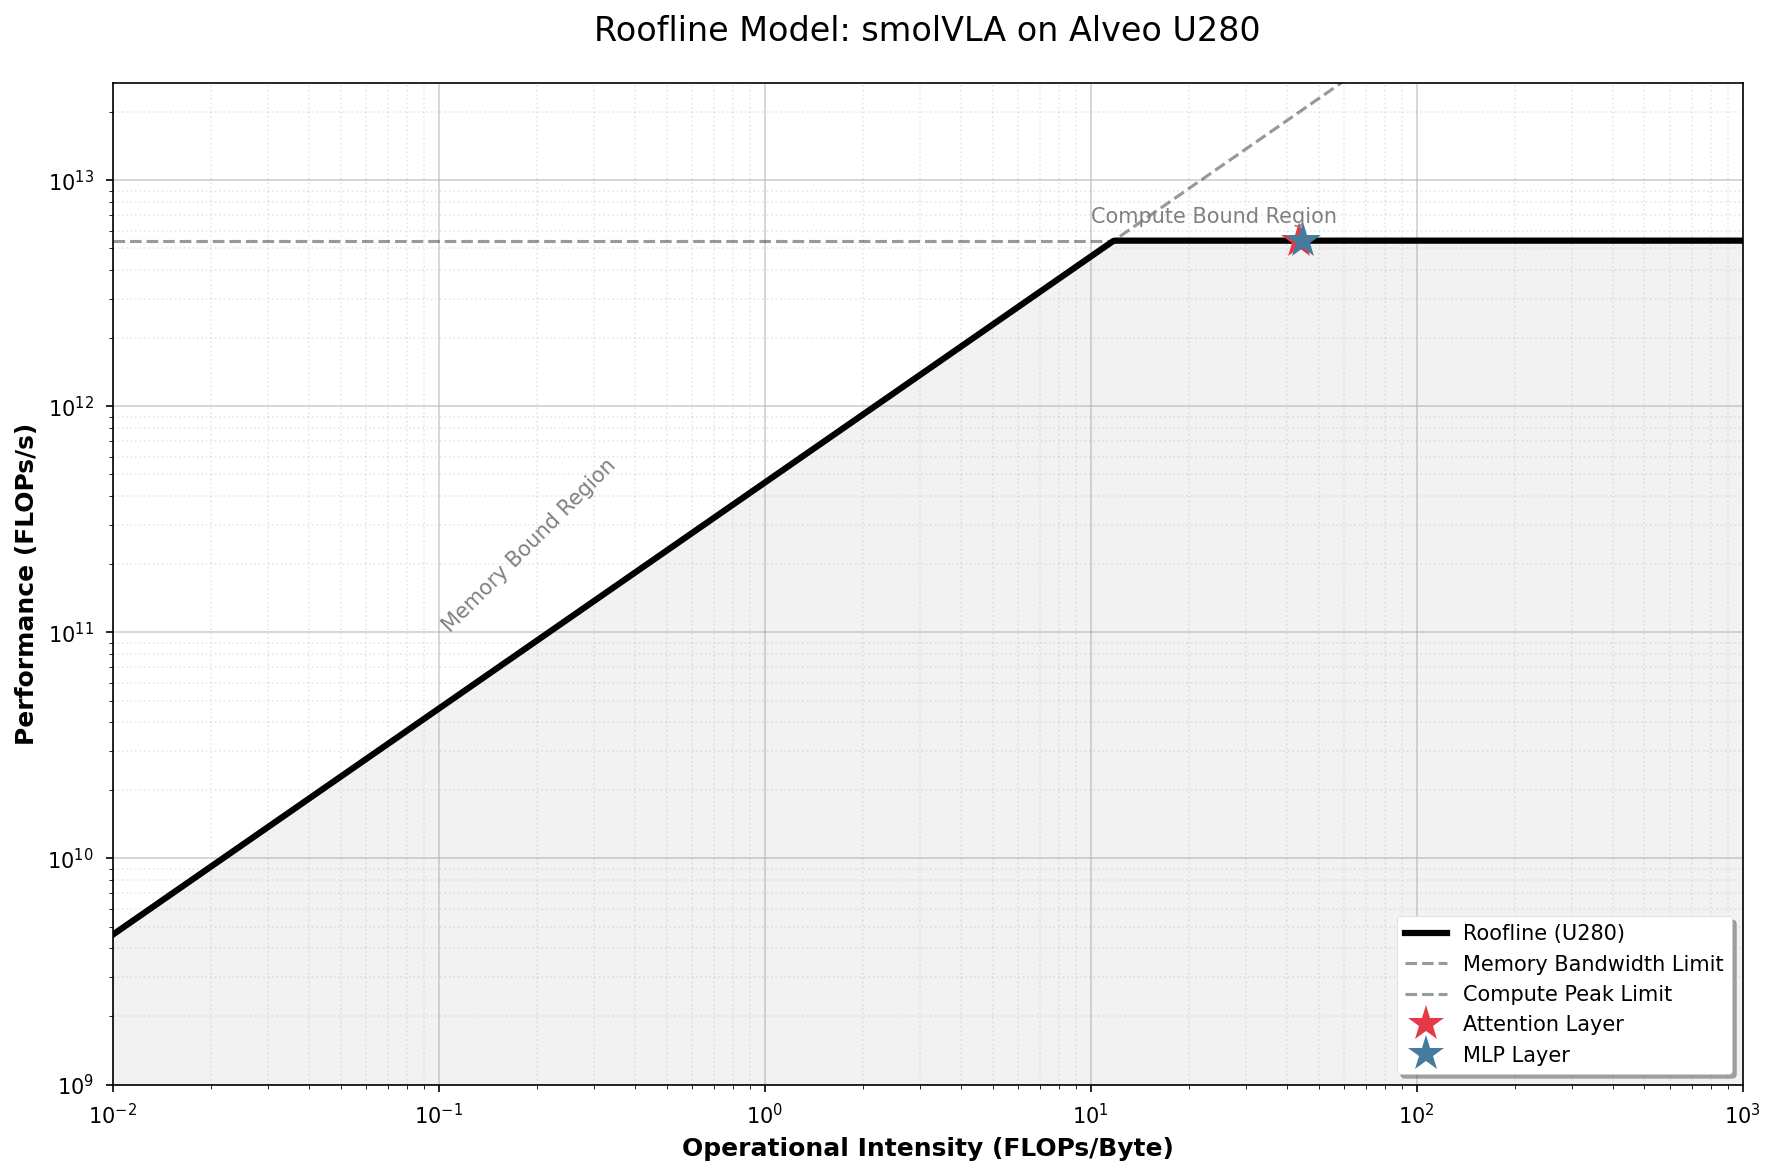

In [ ]:
# Roofline Plotting Logic
fig, ax = plt.subplots(figsize=(12, 8))

# 1. Define the Roofline Curve
x = np.logspace(-2, 4, 1000)
y_mem = x * BW_PEAK
y_compute = np.full_like(x, P_PEAK)
y_roofline = np.minimum(y_mem, y_compute)

# 2. Plot Regions
ax.loglog(x, y_roofline, 'k-', linewidth=3, label='Roofline (U280)')
ax.fill_between(x, y_roofline, 1e-5, color='gray', alpha=0.1) # Shading under the curve

# 3. Plot Limits (Dashed Lines)
ax.loglog(x, y_mem, 'k--', alpha=0.4, linewidth=1.5, label='Memory Bandwidth Limit')
ax.loglog(x, y_compute, 'k--', alpha=0.4, linewidth=1.5, label='Compute Peak Limit')

# 4. Plot Application Points
# Calculate attainable performance for our layers
perf_attn = min(P_PEAK, oi_attn * BW_PEAK)
perf_mlp = min(P_PEAK, oi_mlp * BW_PEAK)

ax.plot(oi_attn, perf_attn, marker='*', markersize=18, color='#E63946', 
        linestyle='None', label='Attention Layer', markeredgecolor='black')
ax.plot(oi_mlp, perf_mlp, marker='*', markersize=18, color='#457B9D', 
        linestyle='None', label='MLP Layer', markeredgecolor='black')

# 5. Annotations and Aesthetics
ax.set_xlabel('Operational Intensity (FLOPs/Byte)', fontweight='bold')
ax.set_ylabel('Performance (FLOPs/s)', fontweight='bold')
ax.set_title('Roofline Model: smolVLA on Alveo U280', fontsize=16, pad=20)

ax.grid(True, which="major", ls="-", alpha=0.6)
ax.grid(True, which="minor", ls=":", alpha=0.3)

# Add text annotations for clarity
ax.text(1e-1, 1e11, 'Memory Bound Region', rotation=45, fontsize=10, color='gray')
ax.text(10, P_PEAK * 1.2, 'Compute Bound Region', fontsize=10, color='gray')

ax.legend(loc='lower right', frameon=True, framealpha=1, shadow=True)

# Set axis limits for better view
ax.set_xlim(1e-2, 1e3)
ax.set_ylim(1e9, P_PEAK * 5)

plt.tight_layout()
plt.show()


## Analysis

The plot above shows the theoretical performance limits.

*   **Attention Layer**: Positioned in the **Memory Bound** region (left of the ridge point). This indicates that the performance is limited by the speed at which we can fetch data from HBM2, rather than the FPGA's compute capability. Optimizations should focus on data reuse or compression.
*   **MLP Layer**: Also likely in the **Memory Bound** region given the parameters, though it may have a slightly higher OI than Attention depending on the exact dimensions.

To achieve higher performance (move up the Y-axis), we must increase Operational Intensity (move right on the X-axis) by performing more operations per byte of data loaded.